In [3]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from mlflow.models.signature import infer_signature
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import argparse

In [4]:
# 引数の処理
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--n_estimators", type=int, default=100, help="Number of trees in the forest")
    parser.add_argument("--max_depth", type=int, default=10, help="Max depth of the trees")
    
    # parse_known_args()を使ってJupyterの不要な引数を無視
    args, unknown = parser.parse_known_args()
    return args

# 引数を取得
args = parse_args()

# MLflowの設定
mlflow.set_tracking_uri("http://mlflow:5010")
mlflow.set_experiment("California Housing Price Prediction")

# モデル名を定義
model_name = "CaliforniaHousingModel"

# California Housing用の実験名を設定
mlflow.set_experiment("California Housing Price Prediction")

# データの読み込みと分割
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 実行ごとに一意の名前を持たせるとより追跡が容易になります
run_name = f"RF Regressor Experiment {time.strftime('%Y-%m-%d %H:%M:%S')}"

# ハッシュ関数でデータバージョン管理
def get_data_hash(data):
    return hashlib.md5(data.tobytes()).hexdigest()

# 使用例: 引数を表示
print(f"Number of estimators: {args.n_estimators}")
print(f"Max depth: {args.max_depth}")

Number of estimators: 100
Max depth: 10


モデル CaliforniaHousingModel はすでに存在します。新しいバージョンを作成します。


Registered model 'CaliforniaHousingModel' already exists. Creating a new version of this model...
2025/06/10 01:32:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CaliforniaHousingModel, version 2
Created version '2' of model 'CaliforniaHousingModel'.


モデルバージョン 2 が作成されました。


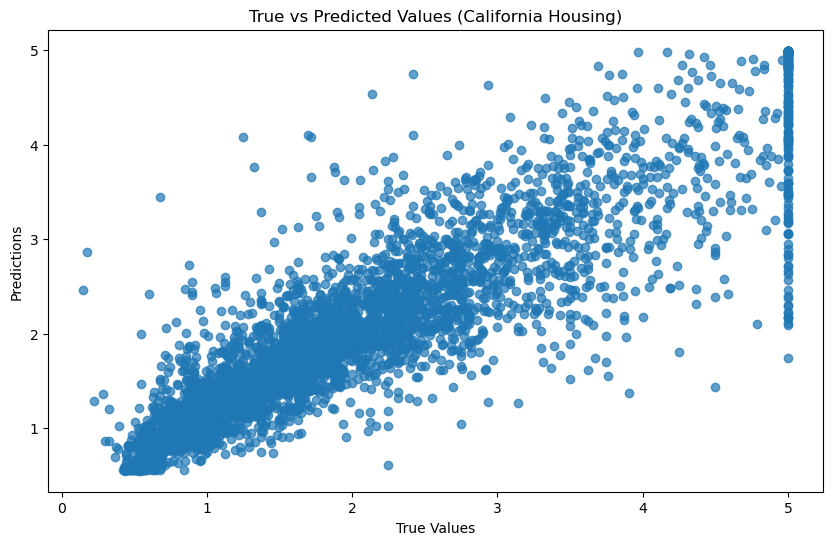

In [5]:
# 実行（Run）の開始
with mlflow.start_run() as run:
    # モデルの構築と評価
    n_estimators = 100
    max_depth = 10
    random_state = 42

    # ランダムフォレスト回帰モデルの作成
    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # 評価メトリクスの計算
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # パラメータとメトリクスの記録
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2_score", r2)

    # データバージョン管理
    data_hash = get_data_hash(X_train)
    mlflow.log_param("data_hash", data_hash)

    # シグネチャの推論
    signature = infer_signature(X_train, y_pred)

    # 入力例の指定
    input_example = X_train[:5]  # 入力データの最初の5行をサンプルとして使用

    # アーティファクトの保存先を指定
    run_id = run.info.run_id
    experiment_id = run.info.experiment_id
    artifacts_dir = os.path.join("mlruns", str(experiment_id), str(run_id), "artifacts")

    # artifactsディレクトリを作成（存在しない場合）
    os.makedirs(artifacts_dir, exist_ok=True)

    # プロットの作成と保存
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted Values (California Housing)')
    
    # プロットをアーティファクトディレクトリに保存
    plot_path = os.path.join(artifacts_dir, "true_vs_predicted.png")
    plt.savefig(plot_path)

    # アーティファクトの記録
    mlflow.log_artifact(plot_path)

    # モデルの保存時にシグネチャと入力例を指定
    mlflow.sklearn.log_model(
        sk_model=reg,
        artifact_path="random_forest_regressor_model",
        signature=signature,
        input_example=input_example
    )

    # モデル登録の処理
    client = MlflowClient()
    model_name = "CaliforniaHousingModel"
    
    try:
        # モデルの登録を試みる
        client.create_registered_model(model_name)
        print(f"モデル {model_name} を新規登録しました。")
    except RestException as e:
        # モデルがすでに存在する場合は新しいバージョンを作成
        if "RESOURCE_ALREADY_EXISTS" in str(e):
            print(f"モデル {model_name} はすでに存在します。新しいバージョンを作成します。")

    # モデルバージョンを登録する
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/random_forest_regressor_model"
    result = mlflow.register_model(model_uri, model_name)
    print(f"モデルバージョン {result.version} が作成されました。")